# Implementing DeepVelo in gastrulation erythroid maturation data

To compare cellDancer with other methods, this notebook shows the prediction of RNA velocity of [DeepVelo](https://www.biorxiv.org/content/10.1101/2022.04.03.486877v2) in gastrulation erythroid maturation. We select 12,329 cells with 2,000 genes from haemato-endothelial progenitors, blood progenitors 1/2, and erythroid 1/2/3. The embryonic days are selected from E7.0, E7.25, E7.5, E7.75, E8.0, E8.25, and E8.5. The selected cells with genes are the same as the datasets used in cellDancer. The input data could be downloaded from [GastrulationErythroid.h5ad](https:DentateGyrus.h5ad).

# Import packages

In [1]:
# %%
import numpy as np
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import velocity, velocity_confidence, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

import anndata as ann

from adata_to_df import adata_to_df
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

# Load gastrulation erythroid maturation data

In [2]:
adata=ann.read_h5ad('your_path/GastrulationErythroid.h5ad')

# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
    "arch":{"args":{"pred_unspliced":True}}, 
    "n_gpu":0, # enable to use CPU
}
configs = update_dict(Constants.default_configs, configs)

scv.pp.neighbors(adata)

# initial velocity
velocity(adata, mask_zero=False)

trainer = train(adata, configs)

adata.write('your_path/GastrulationErythroid_pred_DeepVelo.h5ad')

The ratio of spliced reads is 94.8% (more than 85%). Suggest using coeff_s 1.0.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([12329, 2000])
velo_mat shape: (12329, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
--> added 'cell_specific_alpha' (adata.layers)


# Visualize the phase portraits of sample genes

In [4]:
adata=ann.read('your_path/GastrulationErythroid_pred_DeepVelo.h5ad')
adata.var['velocity_genes']=True
scv.tl.velocity_graph(adata, n_jobs=20)

computing velocity graph (using 20/48 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:00:32) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [5]:
%%capture
# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_TSNE'] was added.
scv.pl.velocity_embedding(
    adata,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=150,
)

In [6]:
# transfer anndata to pandas dataframe
DeepVelo_esti_df_gastrulation=adata_to_df(adata,embed_para='X_umap',embed_pred_para='velocity_umap')
DeepVelo_esti_df_gastrulation

gene_name  unsplice    splice  unsplice_predict  splice_predict  \
0            Sox17  0.000000  0.043971          0.027636        0.032002   
1            Sox17  0.000000  0.000000          0.040762        0.000000   
2            Sox17  0.000000  0.018161          0.038192        0.012879   
3            Sox17  0.000000  0.000000         -0.051275        0.000000   
4            Sox17  0.000000  0.000000         -0.000062        0.000000   
...            ...       ...       ...               ...             ...   
24657995   Gm47283  0.214961  1.145533          0.202252        2.668128   
24657996   Gm47283  0.300111  1.072944         -0.198334        3.451427   
24657997   Gm47283  0.292607  1.199875         -0.020070        3.126271   
24657998   Gm47283  0.266031  1.114659          0.100127        3.021727   
24657999   Gm47283  0.164675  1.111358          0.408267        2.517404   

               cellID             clusters  embedding1  embedding2  velocity1  \
0            cell_363  Blood progenitors 2    3.460521   15.574629   0.031938   
1            cell_382  Blood progenitors 2    2.490433   14.971734   0.033259   
2            cell_385  Blood progenitors 2    2.351203   15.267069   0.020859   
3            cell_393  Blood progenitors 2    5.899098   14.388825   0.018182   
4            cell_398  Blood progenitors 2    4.823139   15.374831   0.039857   
...               ...                  ...         ...         ...        ...   
24657995  cell_139318           Erythroid3    8.032358    7.603037  -0.005068   
24657996  cell_139321           Erythroid3   10.352904    6.446736   0.000782   
24657997  cell_139326           Erythroid3    9.464873    7.261099  -0.007200   
24657998  cell_139327           Erythroid3    9.990495    7.243880  -0.008869   
24657999  cell_139330           Erythroid3    8.260699    7.935455   0.005849   

          velocity2  
0          0.004896  
1          0.011159  
2          0.014695  
3         -0.011803  
4         -0.011217  
...             ...  
24657995   0.049216  
24657996   0.038151  
24657997   0.043951  
24657998   0.052457  
24657999   0.051435  

[24658000 rows x 11 columns]

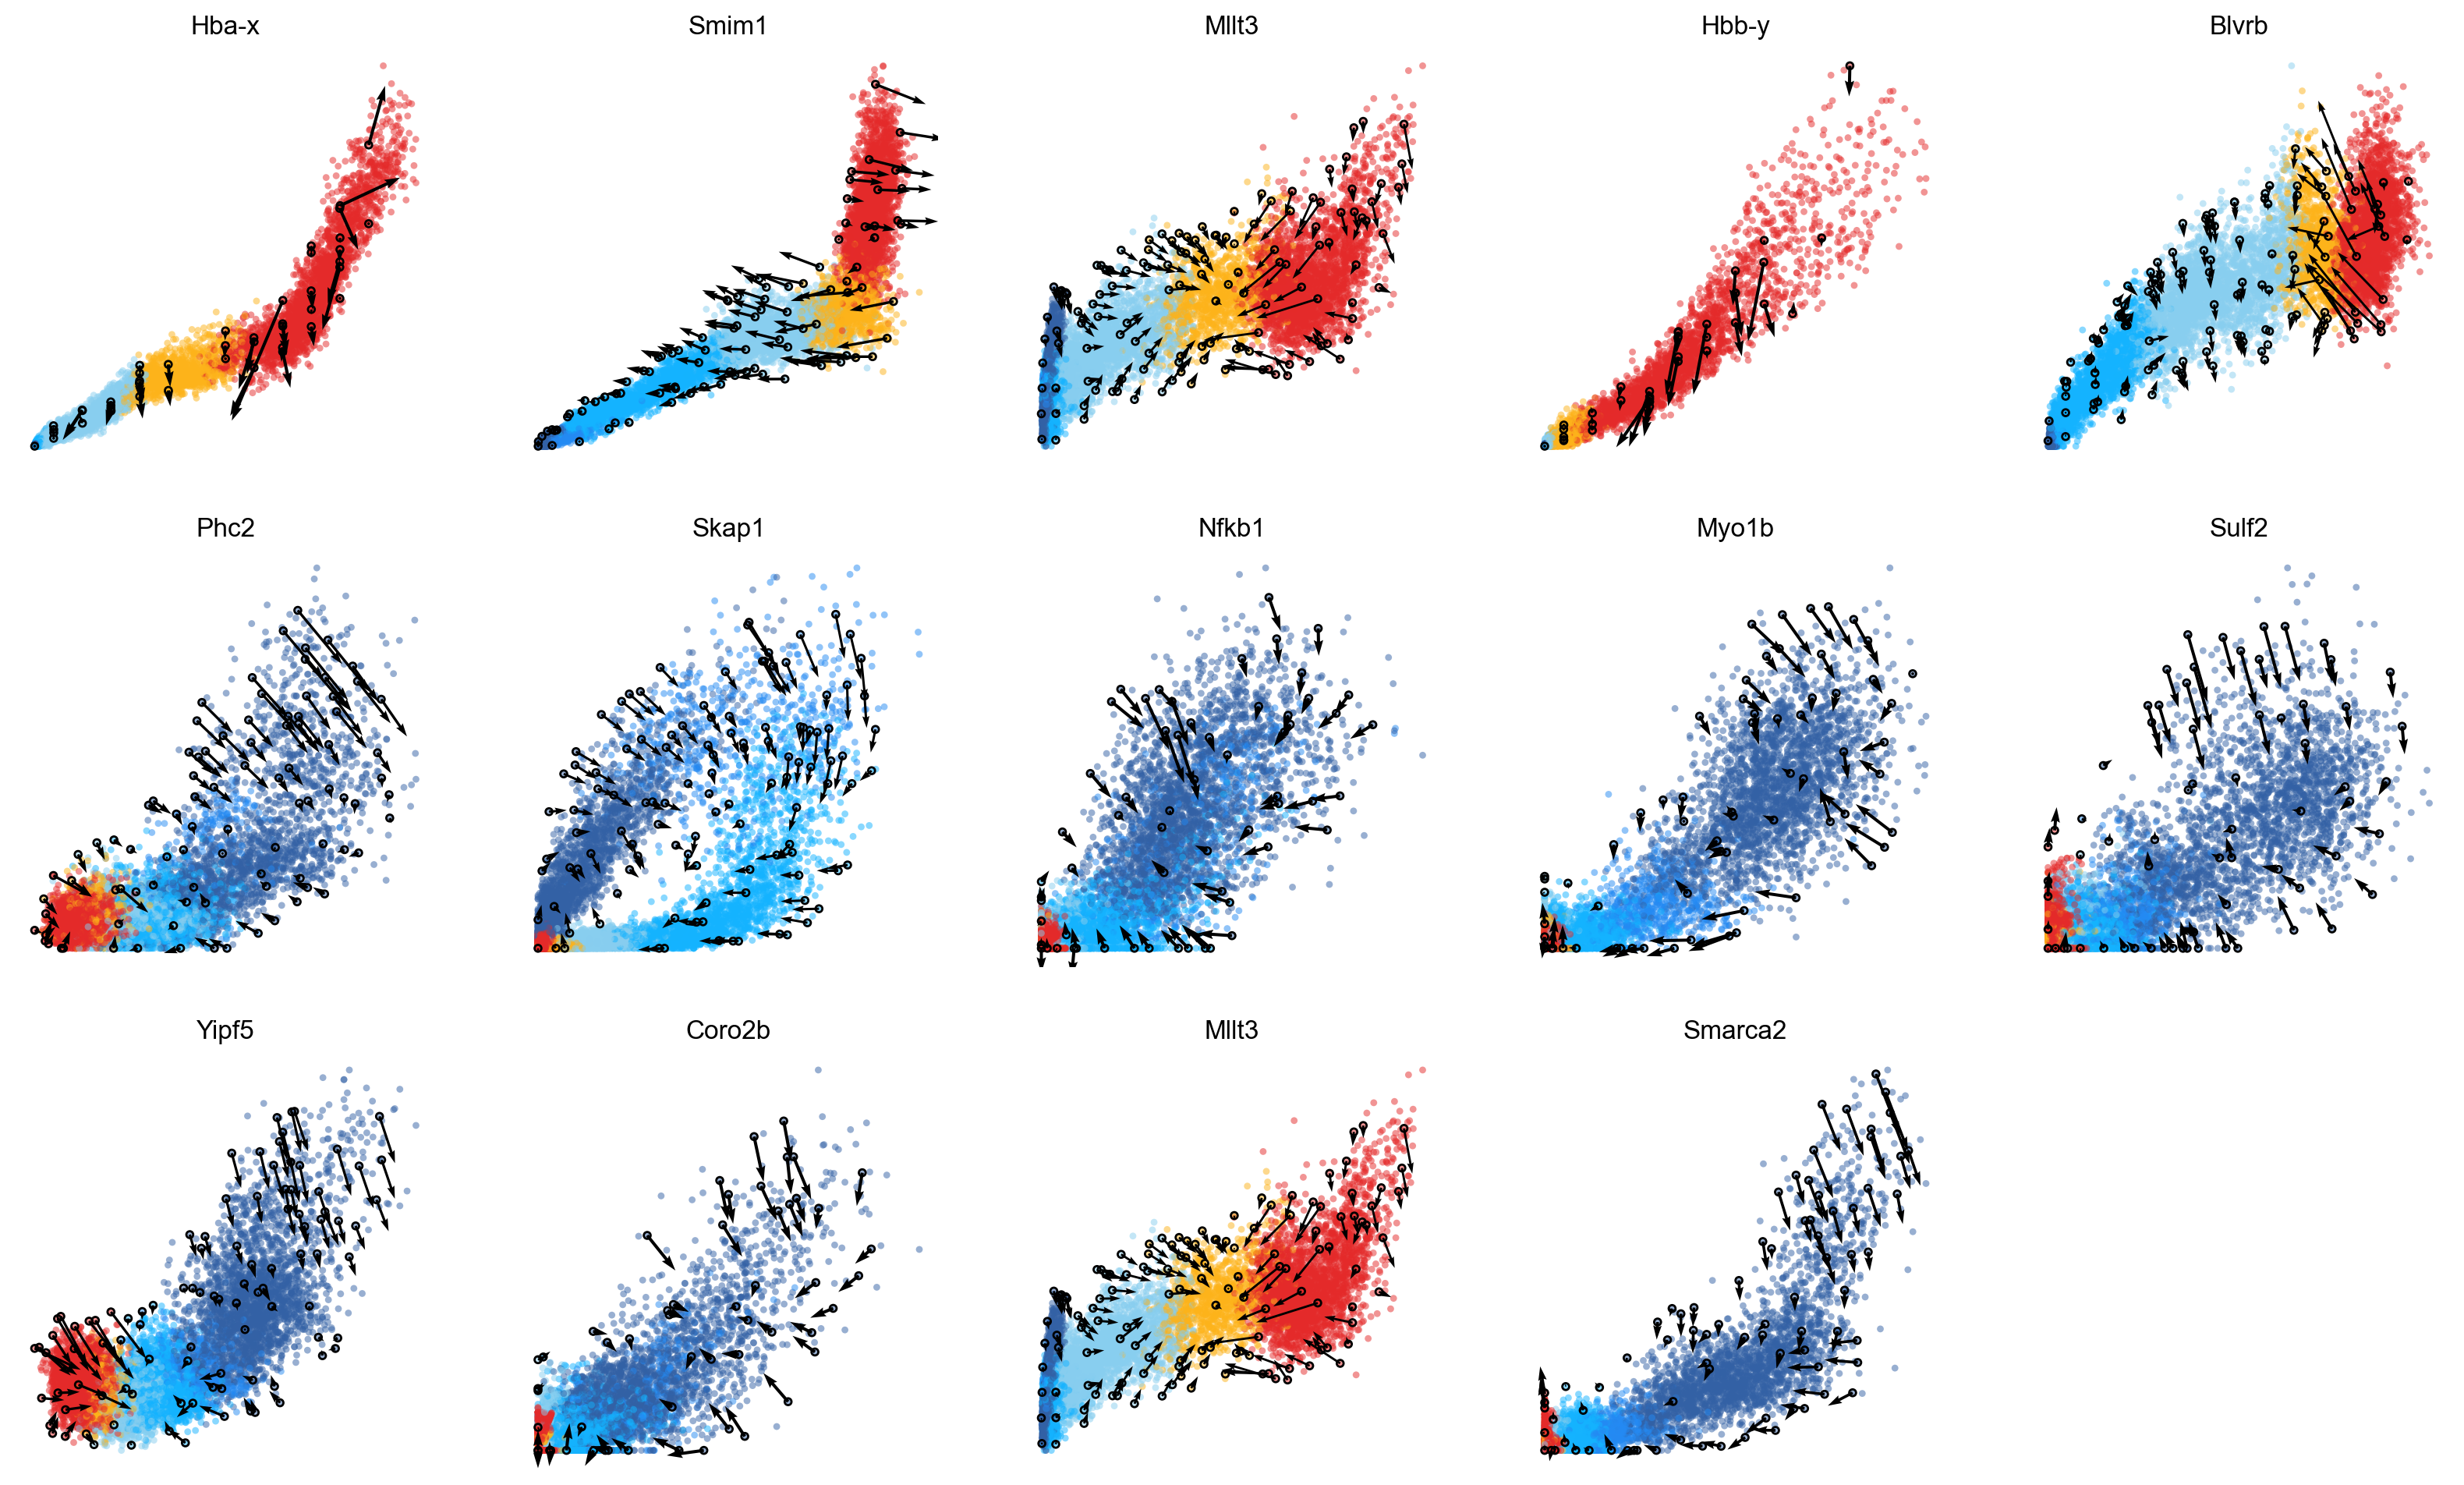

In [7]:
gene_list=['Hba-x','Smim1','Mllt3','Hbb-y','Blvrb','Phc2','Skap1','Nfkb1','Myo1b','Sulf2','Yipf5','Coro2b','Mllt3','Smarca2']

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=DeepVelo_esti_df_gastrulation,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5,
        s = 10,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

# Project the RNA velocity to vector fields in the embedding space

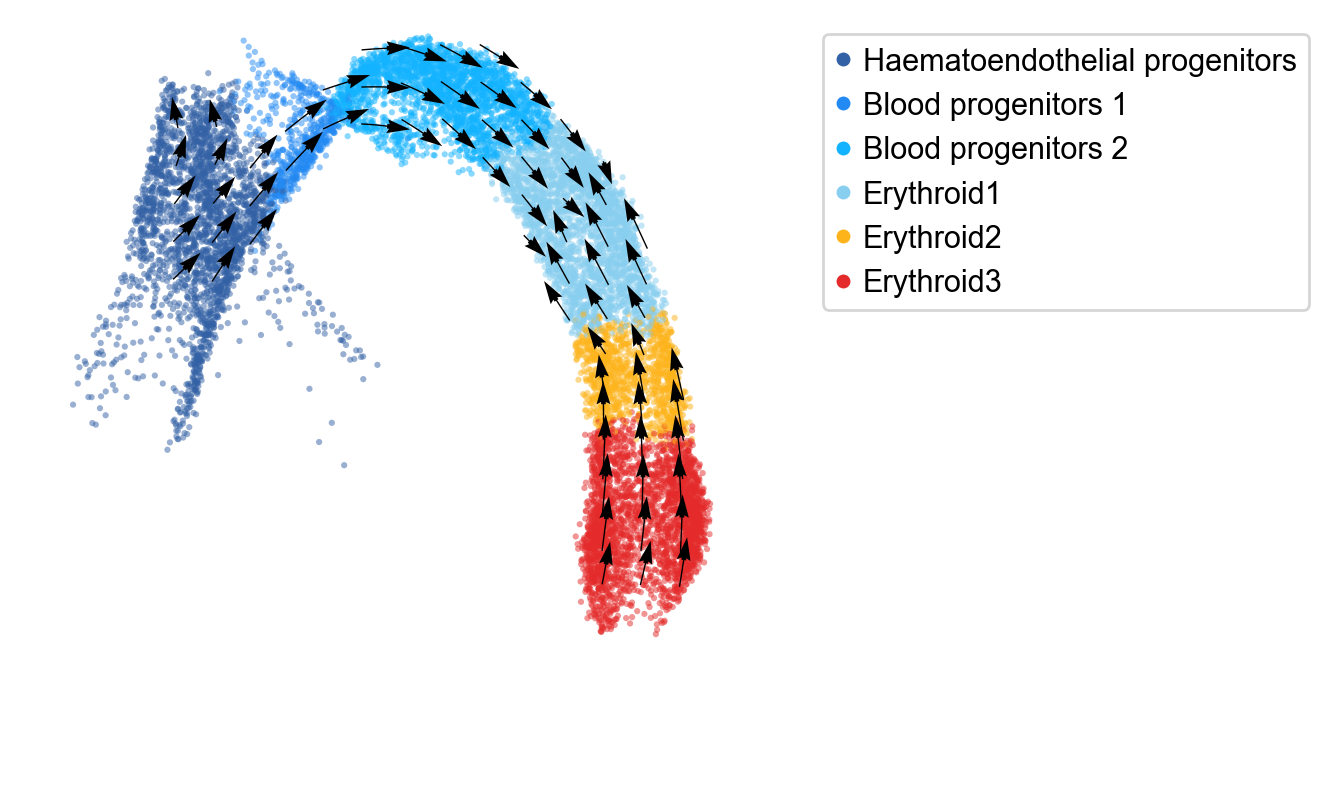

In [8]:
# plot cell velocity
fig, ax = plt.subplots(figsize=(5,5))
cdplt.scatter_cell(ax,
                   DeepVelo_esti_df_gastrulation,
                   colors=colormap.colormap_erythroid,
                   alpha=0.5,
                   s=5,
                   velocity=True,
                   legend='on',
                   min_mass=200,
                   arrow_grid=(20,40),
                   custom_xlim=[-6,13],
                   custom_ylim=[2,16])
ax.axis('off')
plt.show()

# Project the RNA velocity to vector fields in the embedding space for transcriptional boost genes (trained by all genes)

In [9]:
# murk genes
murk_genes=pd.read_csv('your_path/13059_2021_2414_MOESM3_ESM.csv')['index']
adata_murk=adata[:,adata.var_names.isin(murk_genes)]
adata_murk.var['velocity_genes']=True
scv.tl.velocity_graph(adata_murk, n_jobs=20)

computing velocity graph (using 20/48 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
%%capture
# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_TSNE'] was added.
scv.pl.velocity_embedding(
    adata_murk,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=300,
)

In [11]:
# transfer anndata to pandas dataframe
DeepVelo_esti_df_gastrulation_murk=adata_to_df(adata_murk,embed_para='X_umap',embed_pred_para='velocity_umap')
DeepVelo_esti_df_gastrulation_murk

gene_name  unsplice    splice  unsplice_predict  splice_predict  \
0          Mgst3  0.000000  0.119450         -0.067766        0.158376   
1          Mgst3  0.000000  0.097280         -0.051475        0.133137   
2          Mgst3  0.000000  0.107186         -0.050676        0.144023   
3          Mgst3  0.000000  0.402772         -0.078136        0.468327   
4          Mgst3  0.000000  0.202537         -0.079525        0.257405   
...          ...       ...       ...               ...             ...   
752064     Alas2  0.054983  5.450834          0.034221        3.722209   
752065     Alas2  0.036798  6.200462          0.085680        3.940438   
752066     Alas2  0.031082  5.794872          0.084256        3.986459   
752067     Alas2  0.026151  5.638885          0.109768        3.597606   
752068     Alas2  0.049006  5.069890          0.069393        3.200613   

             cellID             clusters  embedding1  embedding2  velocity1  \
0          cell_363  Blood progenitors 2    3.460521   15.574629   0.007367   
1          cell_382  Blood progenitors 2    2.490433   14.971734   0.030117   
2          cell_385  Blood progenitors 2    2.351203   15.267069   0.039858   
3          cell_393  Blood progenitors 2    5.899098   14.388825  -0.034642   
4          cell_398  Blood progenitors 2    4.823139   15.374831  -0.016863   
...             ...                  ...         ...         ...        ...   
752064  cell_139318           Erythroid3    8.032358    7.603037  -0.002907   
752065  cell_139321           Erythroid3   10.352904    6.446736  -0.001569   
752066  cell_139326           Erythroid3    9.464873    7.261099  -0.018370   
752067  cell_139327           Erythroid3    9.990495    7.243880  -0.009608   
752068  cell_139330           Erythroid3    8.260699    7.935455   0.003890   

        velocity2  
0       -0.001019  
1        0.024563  
2        0.025888  
3        0.027383  
4        0.010077  
...           ...  
752064   0.041066  
752065   0.026563  
752066   0.033302  
752067   0.042933  
752068   0.045948  

[752069 rows x 11 columns]

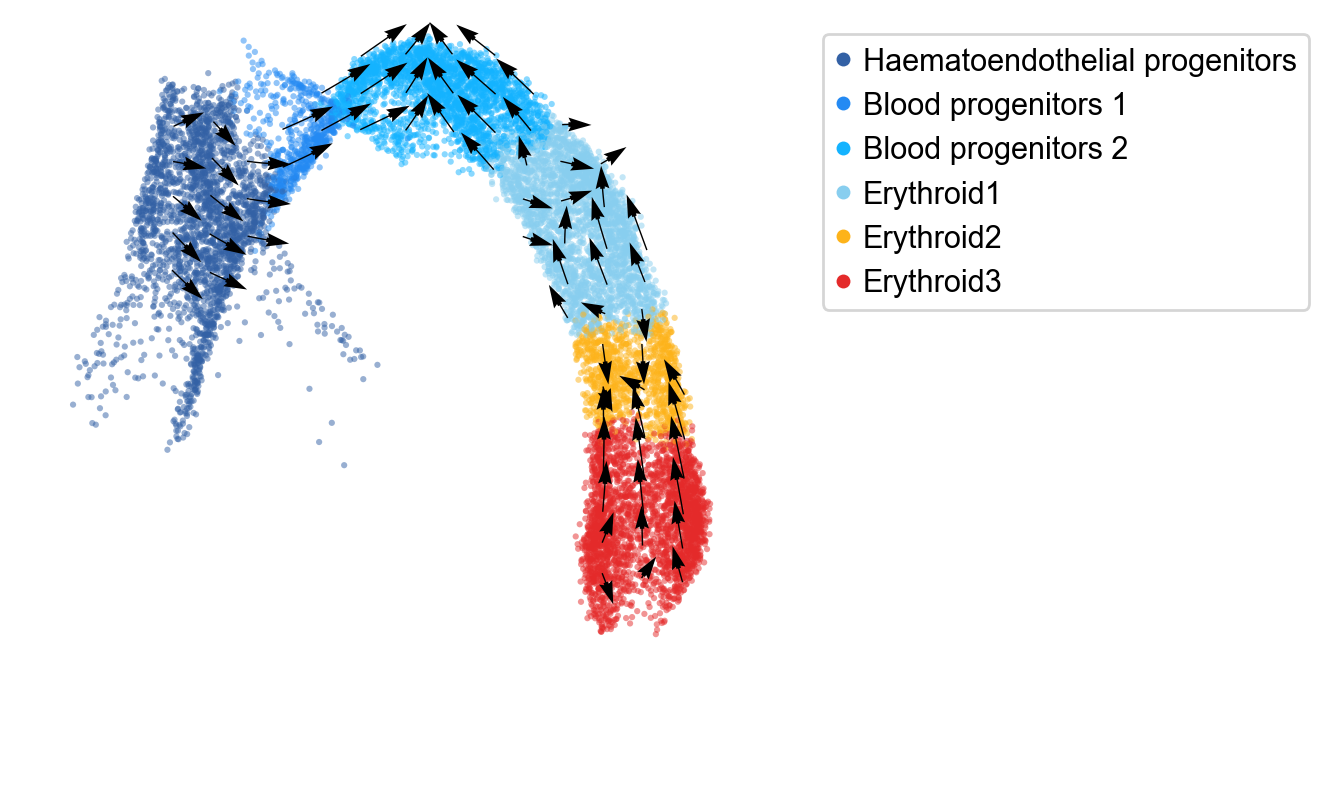

In [12]:
# plot cell velocity
fig, ax = plt.subplots(figsize=(5,5))
cdplt.scatter_cell(ax,
                   DeepVelo_esti_df_gastrulation_murk,
                   colors=colormap.colormap_erythroid,
                   alpha=0.5,
                   s=5,
                   velocity=True,
                   legend='on',
                   min_mass=200,
                   arrow_grid=(20,40),
                   custom_xlim=[-6,13],
                   custom_ylim=[2,16])
ax.axis('off')
plt.show()

# Project the RNA velocity to vector fields in the embedding space for transcriptional boost genes (trained by MURK genes)

In [13]:
adata=ann.read_h5ad('your_path/GastrulationErythroid.h5ad')
# murk genes
murk_genes=pd.read_csv('your_path/13059_2021_2414_MOESM3_ESM.csv')['index']
adata_M_murk=adata[:,adata.var_names.isin(murk_genes)]

## DeepVelo

In [14]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
    "arch":{"args":{"pred_unspliced":True}}, 
    "n_gpu":0, # enable to use CPU
}
configs = update_dict(Constants.default_configs, configs)

scv.pp.neighbors(adata_M_murk)

# initial velocity
velocity(adata_M_murk, mask_zero=False)

trainer = train(adata_M_murk, configs)

adata_M_murk.write('your_path/GastrulationErythroid_MURK_pred_DeepVelo.h5ad')

adata_M_murk.var['velocity_genes']=True
scv.tl.velocity_graph(adata_M_murk, n_jobs=20)

The ratio of spliced reads is 94.8% (more than 85%). Suggest using coeff_s 1.0.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([12329, 61])
velo_mat shape: (12329, 61)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)
--> added 'cell_specific_alpha' (adata.layers)
computing velocity graph (using 20/48 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [15]:
%%capture
# project the RNA velocity to vector fields in the embedding space. adata.layers['velocity_TSNE'] was added.
scv.pl.velocity_embedding(
    adata_M_murk,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=300,
)

In [16]:
# transfer anndata to pandas dataframe
DeepVelo_MURK_esti_df_gastrulation_murk=adata_to_df(adata_M_murk,embed_para='X_umap',embed_pred_para='velocity_umap')
DeepVelo_MURK_esti_df_gastrulation_murk

gene_name  unsplice    splice  unsplice_predict  splice_predict  \
0          Mgst3  0.000000  0.119450          0.944428        0.531934   
1          Mgst3  0.000000  0.097280          1.228371        0.377037   
2          Mgst3  0.000000  0.107186          1.349219        0.451677   
3          Mgst3  0.000000  0.402772         -0.962725        2.335441   
4          Mgst3  0.000000  0.202537          0.052762        0.942687   
...          ...       ...       ...               ...             ...   
752064     Alas2  0.054983  5.450834        -10.514731       -5.925194   
752065     Alas2  0.036798  6.200462         -1.530964       -5.699710   
752066     Alas2  0.031082  5.794872         -6.295455       -6.723308   
752067     Alas2  0.026151  5.638885         -5.682156       -3.800972   
752068     Alas2  0.049006  5.069890        -12.781931       -4.033020   

             cellID             clusters  embedding1  embedding2  velocity1  \
0          cell_363  Blood progenitors 2    3.460521   15.574629  -0.031183   
1          cell_382  Blood progenitors 2    2.490433   14.971734   0.042966   
2          cell_385  Blood progenitors 2    2.351203   15.267069   0.004637   
3          cell_393  Blood progenitors 2    5.899098   14.388825   0.043040   
4          cell_398  Blood progenitors 2    4.823139   15.374831  -0.026574   
...             ...                  ...         ...         ...        ...   
752064  cell_139318           Erythroid3    8.032358    7.603037  -0.002349   
752065  cell_139321           Erythroid3   10.352904    6.446736  -0.004055   
752066  cell_139326           Erythroid3    9.464873    7.261099  -0.025005   
752067  cell_139327           Erythroid3    9.990495    7.243880  -0.016553   
752068  cell_139330           Erythroid3    8.260699    7.935455  -0.017451   

        velocity2  
0       -0.000285  
1        0.007669  
2       -0.002836  
3       -0.025453  
4        0.015762  
...           ...  
752064  -0.021594  
752065   0.028082  
752066   0.033307  
752067   0.042698  
752068  -0.026928  

[752069 rows x 11 columns]

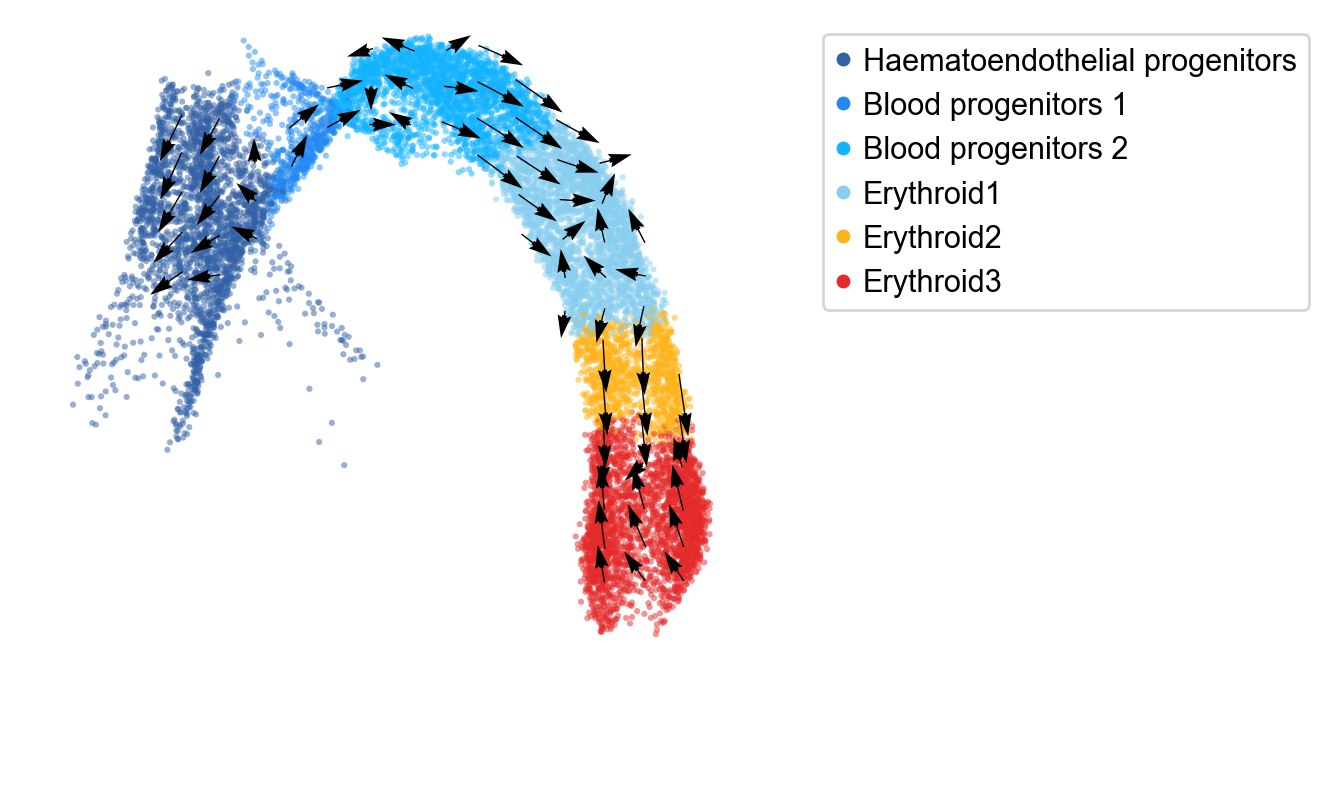

In [17]:
# plot cell velocity
fig, ax = plt.subplots(figsize=(5,5))
cdplt.scatter_cell(ax,
                   DeepVelo_MURK_esti_df_gastrulation_murk,
                   colors=colormap.colormap_erythroid,
                   alpha=0.5,
                   s=5,
                   velocity=True,
                   legend='on',
                   min_mass=200,
                   arrow_grid=(20,40),
                   custom_xlim=[-6,13],
                   custom_ylim=[2,16])
ax.axis('off')
plt.show()

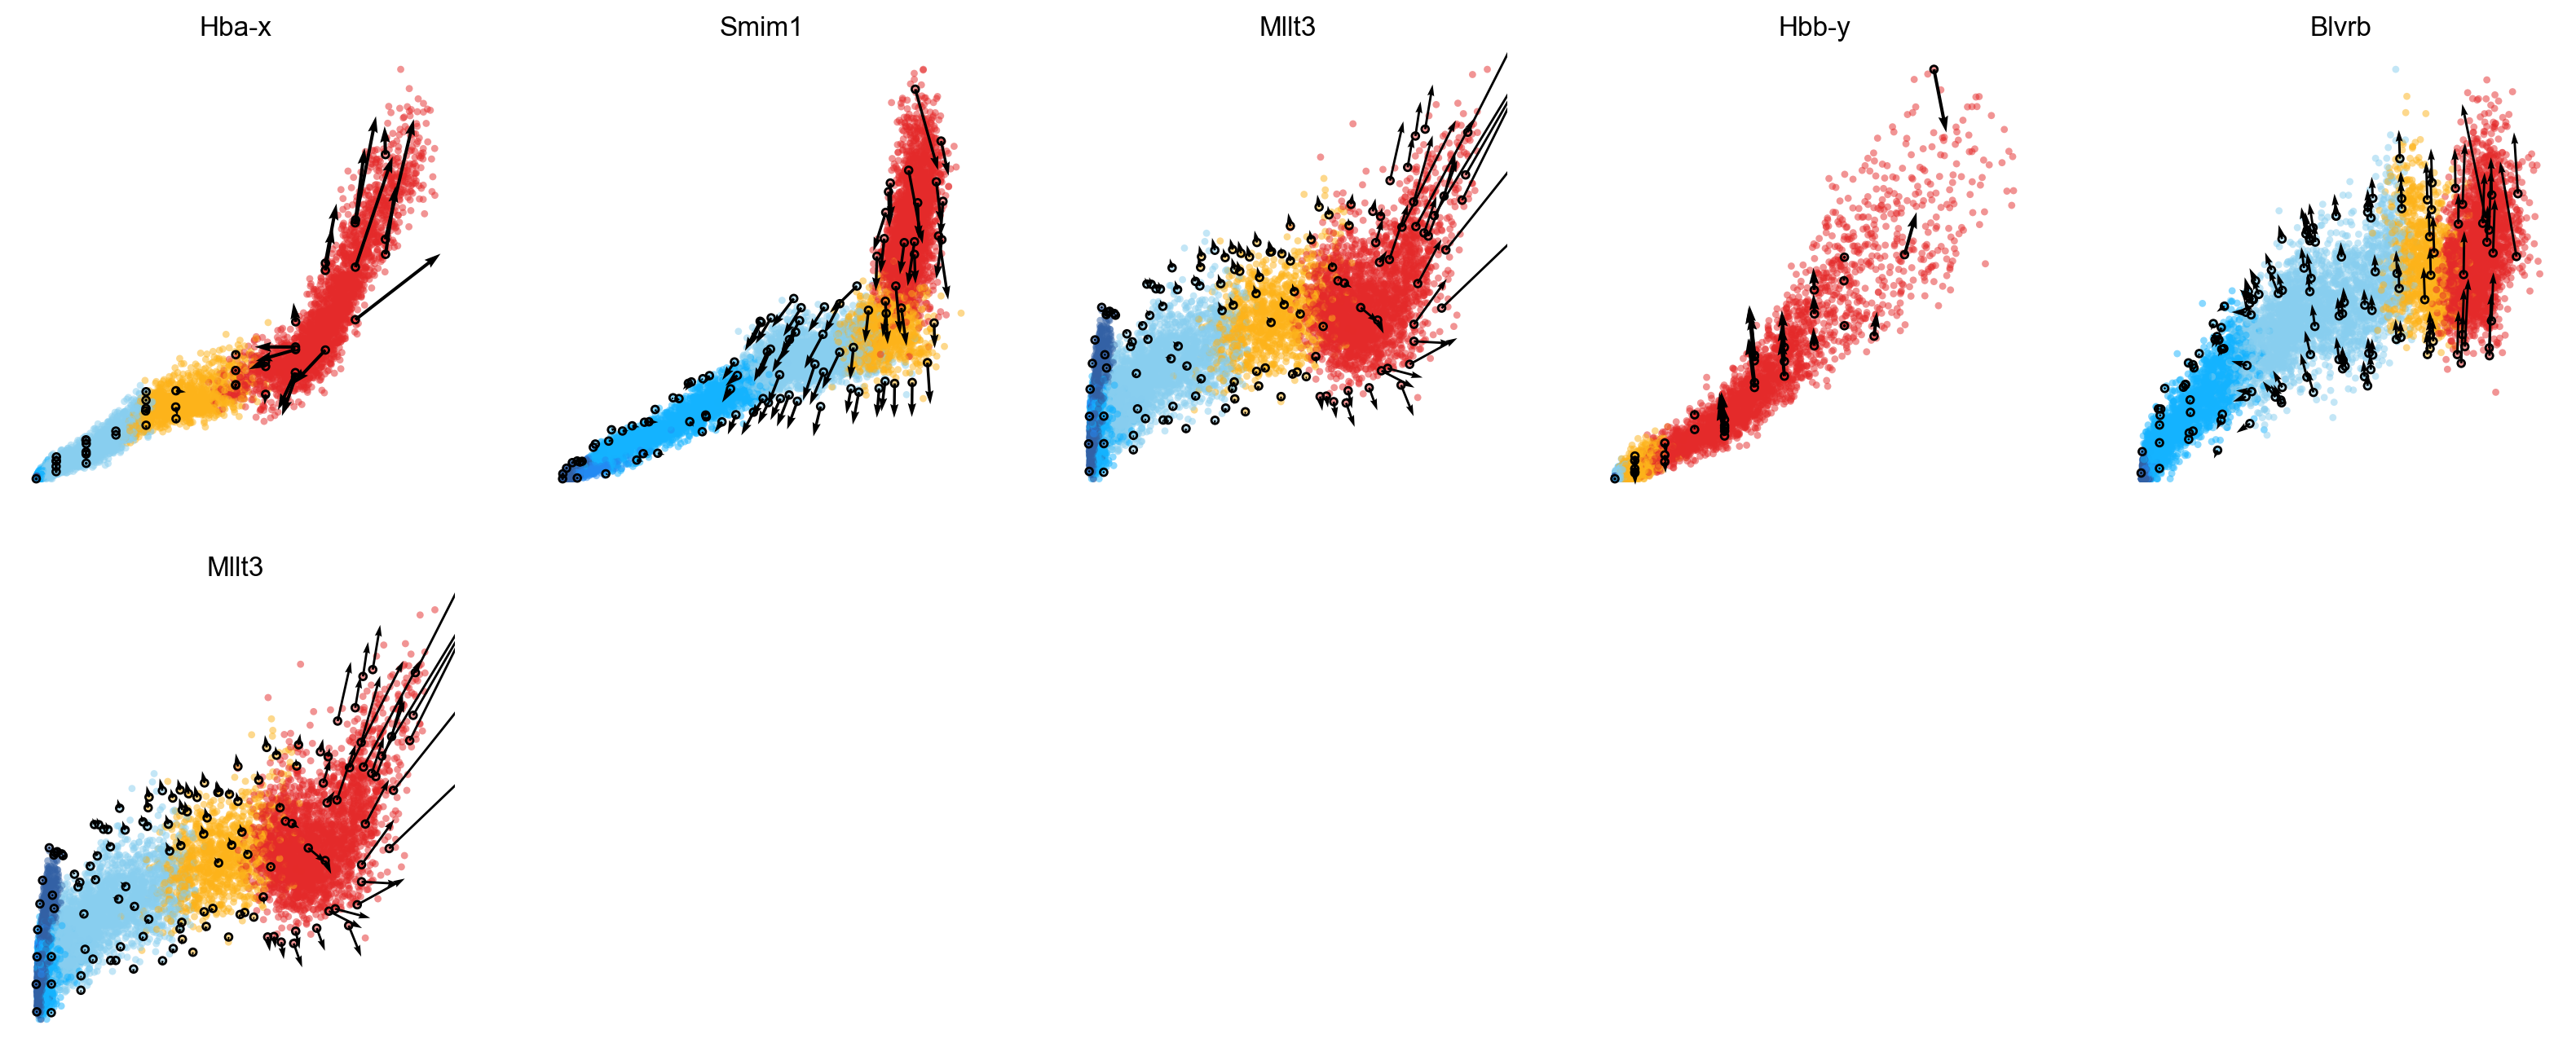

In [18]:
gene_list=['Hba-x','Smim1','Mllt3','Hbb-y','Blvrb','Mllt3']

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=DeepVelo_MURK_esti_df_gastrulation_murk,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5,
        s = 10,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()